In [1]:
import numpy as np
from math import log
import matplotlib.pyplot as plt
import pandas as pd
import time
import pywt
import numpy as np
import cv2
#from google.colab.patches import cv2_imshow
from skimage import io, color
import pywt
from PIL import Image
import imagehash
from matplotlib import cm
from sklearn.model_selection import KFold
import math
import mpmath as mp

# Classe

In [46]:
'''
Ce code définit les classes qui vont être utilisées par la suite dans le projet 
'''


#la Classe random contient les fonctions qui simulent les variables aléatoires qui seront utilisée pour étudier les données simulés.

print("classes imported")
class random:  
    def matrix_normal(n,p,mu=0,sigma=1):  # n est le nombre de lignes et p le nombre des colonnes, mu est la moyenne et sigma est l'écart type
        return (np.random.randn(n,p)*(sigma**2))+mu
    def vect_normal(n,mu=0,sigma=1):
        return (np.random.randn(n)*(sigma**2))+mu
    def beta(a,s,n): # s et a sont à préciser tel que s= 0,1*p et n> 2*s*log(p/2) pour commencer on peut utilisr a=1
        return a*(np.random.binomial(1,s/n , size=(n,)))
    def outcome(n,p,a,s,mu=0,sigma=1):
        X=random.matrix_normal(n,p,mu,sigma)
        beta=random.beta(a,s,p)
        epsilon=random.vect_normal(n,mu,sigma)
        Y=X @ beta+epsilon
        return Y,X,beta,epsilon


#la classe algo contient les algorithmes qui seront utilisés nottament ISTA et IHT
class algo:


    def HardThreshold(x,lamda):
        return x*(np.abs(x)>=lamda)
    def SoftThreshold(x, threshold):
        return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)


    def IHT(X, Y,threshold,beta=np.zeros(1) ,C=0.9,step=0.0000001,max_iterations=3000,lamda=0.1, tol=1e-6,sparse='False'):
        n,m=X.shape
        Z,beta_hat=np.zeros(m),np.ones(m)
        loss=[]
        cost=[]
        check_vect=np.zeros(m)
        test=np.zeros(1)
        sparsity=[]
        if np.array_equal(beta, test, equal_nan=False):
          beta=beta_hat.copy()
          print('We are in the unknow beta case,the cost function is not significant')
        start_time = time.time()        
        for i in range(max_iterations):
            Z=beta_hat+(step*(X.T)@(Y-X@beta_hat))
            beta_hat=algo.HardThreshold(Z, lamda)
            cost.append(np.linalg.norm(-beta+beta_hat))
            sparsity.append(theoretical_coeff.indice_sparsite(beta_hat))
            while lamda > threshold:
              lamda*=C
            loss.append(np.linalg.norm(Y-(X@beta_hat)))
            #if np.linalg.norm(beta_hat -check_vect ) < tol:
                #break
        end_time = time.time()
        time_taken = end_time - start_time
        print("IHT execution time :", time_taken, "seconds")

        return beta_hat,cost,loss,sparsity
    def IHT_CV(X, Y, lamda,beta=np.zeros(1), C=0.9, step=0.001, max_iterations=3000, lamda_list=[0.2,0.4,1,1.8,2], n_folds=5):
      kf = KFold(n_splits=n_folds, shuffle=True)
      min_distance = np.inf
      for threshold in lamda_list:
        avg_distance = 0
        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            Y_train, Y_test = Y[train_idx], Y[test_idx]
            beta_hat, cost, loss, sparsity = algo.IHT(X_train, Y_train, threshold=threshold, beta=beta, C=C, step=step, max_iterations=max_iterations, lamda=lamda)
            Y_pred = X_test @ beta_hat
            avg_distance += np.linalg.norm(Y_pred - Y_test)
        avg_distance /= n_folds
        if avg_distance < min_distance:
            min_distance = avg_distance
            CV_threshold = threshold
      print(f"The best lamda according to the cross validation process is equal to: {CV_threshold}")
      return CV_threshold

    def ISTA(X, Y,beta=np.zeros(1) ,step=0.0001,max_iterations=3000,lamda=0.01, tol=1e-6,):
        n,m=X.shape
        Z,beta_hat=np.zeros(m),np.ones(m)
        check_vect=np.zeros(m)
        test=np.zeros(1)
        cost=[]
        loss=[]
        sparsity=[]
        if np.array_equal(beta, test, equal_nan=False):
          beta=beta_hat.copy()
          print('We are in the unknow beta case,the cost function is not significant')
        start_time = time.time()
        for i in range(max_iterations):
            Z=beta_hat+(step*(X.T)@(Y-X@beta_hat))
            beta_hat=algo.SoftThreshold(Z, lamda)
            cost.append(np.linalg.norm(-beta+beta_hat))
            loss.append(np.linalg.norm(Y-(X@beta_hat)))
            sparsity.append(theoretical_coeff.indice_sparsite(beta_hat))
            #if np.linalg.norm(beta_hat -check_vect ) < tol:
                #break
        end_time = time.time()
        time_taken = end_time - start_time
        print("ISTA execution time :", time_taken, "seconds")
        return beta_hat,cost,loss,sparsity

class image_processing:
    def read_image(img_path):
      imgRGB = io.imread(img_path)
      return(np.array(imgRGB.flatten()))
    
    def compress_image_BW(img_path, wavelet_type='haar', threshold=20):
      '''
      ENG:
      In this code, cA, cH, cV, and cD are the coefficients obtained after applying a two-dimensional discrete wavelet transform (DWT) 
      to the input grayscale image.cA represents the approximation coefficients, which contain the coarsest approximation of the input image.
      cH, cV, and cD represent the horizontal, vertical, and diagonal detail coefficients, respectively. These coefficients contain information
      about the high-frequency components of the image in each of these directions.Together, these four sets of coefficients contain all of the 
      information about the original image, but at different scales and resolutions.

      FR: 
      Dans ce code, cA, cH, cV et cD sont les coefficients obtenus après l'application d'une transformation en ondelettes discrètes à deux dimensions (DWT) 
      à l'image en niveaux de gris d'entrée.cA représente les coefficients d'approximation, qui contiennent l'approximation la plus grossière de l'image 
      d'entrée.cH, cV et cD représentent les coefficients de détails horizontaux, verticaux et diagonaux, respectivement. Ces coefficients contiennent 
      des informations sur les composantes haute fréquence de l'image dans chacune de ces directions.Ensemble, ces quatre ensembles de coefficients
      contiennent toutes les informations sur l'image d'origine, mais à différentes échelles et résolutions.
      '''
    # telecharger l'image
      img = cv2.imread(img_path, 0)
    # on applique la transofomation en ondellettes de dimension 2
      coeffs = pywt.dwt2(img, wavelet_type)
      cA, (cH, cV, cD) = coeffs
    #on stock les dimention de ces vecteurs afin de pouvoir les récuperer dans un second lieu
      coeff_size=[cA.size,cH.size,cV.size]
      coeff_shape=[cA.shape,cH.shape,cV.shape,cD.shape]
    # construire notre vecteur sparse qui contient toutes les infomations
      coef_vec = np.concatenate((cA.flatten(), cH.flatten(), cV.flatten(), cD.flatten()))
      coef_vec[np.abs(coef_vec) < threshold] = 0
      return coef_vec,coeff_size,coeff_shape

    
    def decompress_photo_BW(coef_vec,coeff_size,coeff_shape, wavelet_type='haar'):
    # on récupere les vecteurs que la transofomation en ondelettes a sorti
      cA_size=coeff_size[0]
      cH_size=coeff_size[1]
      cV_size=coeff_size[2]
      cA_thresh = coef_vec[:cA_size].reshape(coeff_shape[0])
      cH_thresh = coef_vec[cA_size:cA_size+cH_size].reshape(coeff_shape[1])
      cV_thresh = coef_vec[cA_size+cH_size:cA_size+cH_size+cV_size].reshape(coeff_shape[2])
      cD_thresh = coef_vec[cA_size+cH_size+cV_size:].reshape(coeff_shape[2])
      coeffs_thresh = cA_thresh, (cH_thresh, cV_thresh, cD_thresh)
      # on reconstruit l'image
      img_thresh = pywt.idwt2(coeffs_thresh, wavelet_type)
      return img_thresh

    def compress_image_RGB(img_path, wt='haar',threshold=20 ,n_lev=2, compression_value=0):

      '''
      FR:
      Dans ce code, Y, Cb et Cr sont les trois canaux d'une image en couleur convertie 
      de l'espace de couleur RGB à l'espace de couleur YCbCr.Y représente la composante
      de luminance ou de luminosité de l'image, et elle contient des informations en 
      niveaux de gris. Cb et Cr sont les composantes de différence de chrominance ou
      de couleur de l'image, et elles représentent respectivement la différence de 
      bleu et la différence de rouge.
      ENG:
      In this code, Y, Cb, and Cr are the three channels of a color image converted from RGB to YCbCr color space.
      Y represents the luma or brightness component of the image, and it contains grayscale information. Cb and Cr 
      are the chroma or color difference components of the image, and they represent the blue-difference and 
      red-difference respectively.
      '''
    # Load image
      imgRGB = io.imread(img_path)

    # Convert to YCbCr
      imgYCbCR = color.rgb2ycbcr(imgRGB)
      Y = imgYCbCR[:, :, 0]
      Cb = imgYCbCR[:, :, 1]
      Cr = imgYCbCR[:, :, 2]

    # Perform wavelet transform
      Y_coeff_arr, Y_coeff_slices = pywt.coeffs_to_array(pywt.wavedec2(Y, wavelet=wt, level=n_lev))
      Cb_coeff_arr, Cb_coeff_slices = pywt.coeffs_to_array(pywt.wavedec2(Cb, wavelet=wt, level=n_lev))
      Cr_coeff_arr, Cr_coeff_slices = pywt.coeffs_to_array(pywt.wavedec2(Cr, wavelet=wt, level=n_lev))
      Y_coeff_arr_n,Cb_coeff_arr_n, Cr_coeff_arr_n, = np.array(Y_coeff_arr) ,np.array(Cb_coeff_arr), np.array(Cr_coeff_arr)


    # Compress wavelet coefficients
      Y_coeff_arr_comp = np.where(np.abs(Y_coeff_arr_n) > compression_value * np.max(np.abs(Y_coeff_arr)),Y_coeff_arr,0)
      Cb_coeff_arr_comp = np.where(np.abs(Cb_coeff_arr_n) > compression_value * np.max(np.abs(Cb_coeff_arr)), Cb_coeff_arr, 0)
      Cr_coeff_arr_comp = np.where(np.abs(Cr_coeff_arr_n) > compression_value * np.max(np.abs(Cr_coeff_arr)), Cr_coeff_arr, 0)
      coeff_size=[Y_coeff_arr_comp.size,Cb_coeff_arr_comp.size,Cr_coeff_arr_comp.size]

      coeff_shape=[Y_coeff_arr.shape, Cb_coeff_arr.shape, Cr_coeff_arr.shape]
      coef_vec=np.concatenate((Y_coeff_arr.flatten(), Cb_coeff_arr.flatten(),Cr_coeff_arr.flatten()))
      slices=[Y_coeff_slices,Cb_coeff_slices,Cr_coeff_slices]
      return coef_vec, slices,coeff_size,coeff_shape


    
    def decompress_photo_RGB(coef_vec,slices,coeff_size,coeff_shape,wt='haar'):

      Y_shape = coeff_shape[0]
      Cb_shape = coeff_shape[1]
      Cr_shape = coeff_shape[2]
      #reconstruct matrices
      Y_coeff_slices = slices[0]
      Cb_coeff_slices = slices[1]
      Cr_coeff_slices = slices[2]
  
      Y_coeff_arr_filt = coef_vec[0:coeff_size[0]].reshape(Y_shape)
      Cb_coeff_arr_filt = coef_vec[coeff_size[0]:coeff_size[0] + coeff_size[1]].reshape(Cb_shape)
      Cr_coeff_arr_filt = coef_vec[coeff_size[0] + coeff_size[1]:].reshape(Cr_shape)
      # Reconstruct images from compressed wavelet coefficients
      Y_compressed = pywt.waverec2(pywt.array_to_coeffs(Y_coeff_arr_filt, Y_coeff_slices, output_format='wavedec2'), wavelet=wt)
      Cb_compressed = pywt.waverec2(pywt.array_to_coeffs(Cb_coeff_arr_filt, Cb_coeff_slices, output_format='wavedec2'), wavelet=wt)
      Cr_compressed = pywt.waverec2(pywt.array_to_coeffs(Cr_coeff_arr_filt, Cr_coeff_slices, output_format='wavedec2'), wavelet=wt)

      # Convert back to RGB and stack the channels
      
      img_compressed = color.ycbcr2rgb(np.dstack((Y_compressed, Cb_compressed, Cr_compressed)))
      img_compressed = Image.fromarray((img_compressed* 255).astype(np.uint8))
      Cb_img=Image.fromarray((Cb_compressed* 255).astype(np.uint8))
      Cr_img=Image.fromarray((Cr_compressed* 255).astype(np.uint8))
      Y_img=Image.fromarray((Y_compressed* 255).astype(np.uint8))
      return img_compressed,Y_img,Cb_img,Cr_img
class theoretical_coeff:
    def universal_separation(sigma,X,s):
      n,p=X.shape
      return sigma*math.sqrt(2*log(p/s)/n)
    def IHT_nb_itteration(beta,X):
      n,p=X.shape
      s=np.count_nonzero(beta)
      nominator=n*(np.linalg.norm(beta)**2)
      dominator= s*log(int(mp.exp(p)/s))
      return log(nominator/dominator)
    def norme_two_infini(X):
      X_j=np.linalg.norm(X, axis=0)
      return(np.max(X_j))
    def M(X,Y):
      step=1/(theoretical_coeff.norme_two_infini(X)**2)
      return step*(X.T@Y)


    def lamda_zero(X,Y):
      n,p=X.shape
      sigma_0= np.linalg.norm(Y)/math.sqrt(n)
      M=random.M(X,Y)
      M_1=max(np.abs(M))
      e=math.exp(1)
      norme_2_infini_X=theoretical_coeff.norme_two_infini(X)
      left=math.sqrt(20)*M_1
      right=(sigma_0/norme_2_infini_X)*math.sqrt(160*log(e*p))
      return int(max(left,right))
    def number_of_step(X,beta,lamda_zero,C,sigma=1):
      n,p=X.shape
      s=np.count_nonzero(beta)
      e=math.exp(1)
      norme_2_infini_X=theoretical_coeff.norme_two_infini(X)
      nominator=s*(lamda_zero**2)*(norme_2_infini_X**2)
      dominator=(sigma**2)*s*(math.log(e*p/s))
      inside_log=max(2,nominator/dominator)
      log=math.log(inside_log)
      return log/(math.log(1/C))
    def indice_sparsite(vector):
      return((float(np.count_nonzero(vector))/float(vector.size)))
    def proxy_sparsité(v):
      norm1_v =np.abs(v).sum()
      norm2_v = np.sqrt(np.sum(np.square(v)))
      p = v.shape[0]  # p est la dimension de v
      prox_sparsity= (norm1_v / (np.sqrt(p) * norm2_v))
      return prox_sparsity
    def compression_dimension(vector):
      s=np.count_nonzero(vector)
      return int((-3)*s*(log(theoretical_coeff.proxy_sparsité(vector))))



classes imported


##données simulées


Les paramètres: n_it pour le nombres d'itération qu'on souhaite fixer pour l'execution des différents algorithmes 

In [4]:
n_it=700

les paramètres pour définir la taille et les caractéristiques des vecteurs qui représentent les données simulées. p et s représentent la taille de la matrice X qui simule un vecteur normal de paramètres $E$[X]=1 et $V$[X]=0. 
Quant à s et a sont les paramètres qu'il faut préciser pour la simulation de la variable $\beta$ qui simule un vecteur aléatoire de lois binomiale. s et a sont à préciser tel que s= 0,1*p et p> 2*s*log(n/2). $\alpha$ est un vecteur qui contient les différentes valeurs de alpha qu'on va utiliser pour exécuter les différents algorithmes. 

In [5]:
n=4000
p=6000
a=10
s=0.1*p
lamda_ista=10
lamda_IHT=300
C=0.88
step=0.0001

In [6]:
Y,X,beta,epsilon=random.outcome(n,p,a,s)

##Data visualisation
Dans cette partie on essaye de représenter la fonction coût pour 100 valeurs différentes d'alpha. Dans un premier temps on fait la représentation pour l'algorithme ISTA et FISTA d'un coté.Dans un second temps on fait la repésentation des 2 courbes superposées. Cette visualisation permet de suggérer que l'algorithme FISTA converge plus rapidement. La section suivante vise à mener une étude statistique sur ces deux fonction de coût

##ISTA

In [53]:
betahat_ista,cost_ista,loss_ista,sparsity_ista=algo.ISTA(X,Y,beta,max_iterations=n_it)
nbr_it = list(range(1,len(cost_ista)+1))

ISTA execution time : 175.81582021713257 seconds


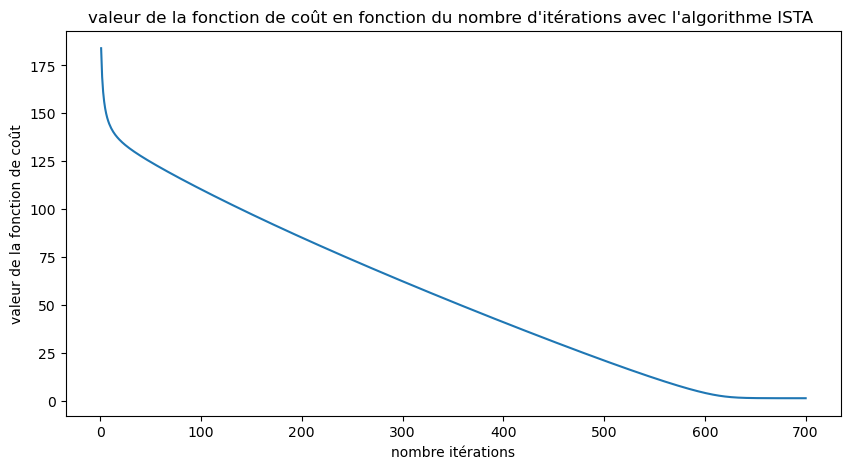

In [54]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(nbr_it,cost_ista)
plt.title("valeur de la fonction de coût en fonction du nombre d'itérations avec l'algorithme ISTA ")  # Titre du graphique
plt.ylabel('valeur de la fonction de coût')  # Titre de l'axe y
plt.xlabel('nombre itérations')
plt.show()

#ce graphique représente la vitesse de convergence en fonction du nombre d'itération de la fonction de coût de l'algorithme ISTA

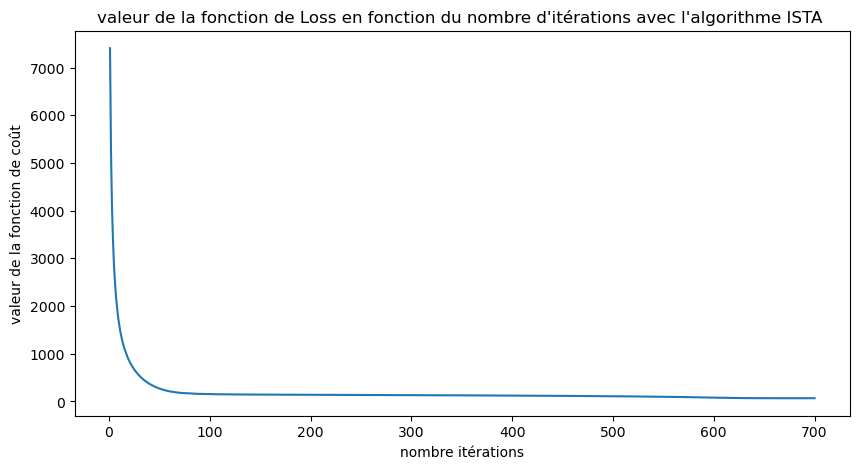

In [9]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(nbr_it,loss_ista)
plt.title("valeur de la fonction de Loss en fonction du nombre d'itérations avec l'algorithme ISTA ")  # Titre du graphique
plt.ylabel('valeur de la fonction de coût')  # Titre de l'axe y
plt.xlabel('nombre itérations')
plt.show()

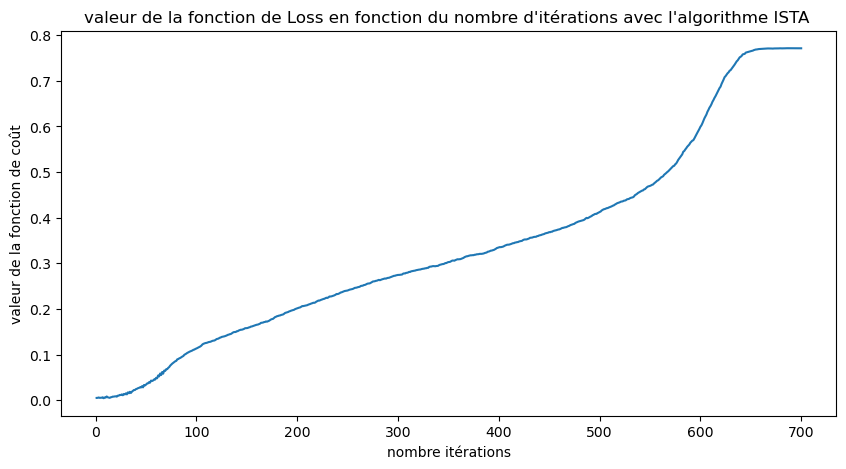

In [10]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(nbr_it,sparsity_ista)
plt.title("valeur de la fonction de Loss en fonction du nombre d'itérations avec l'algorithme ISTA ")  # Titre du graphique
plt.ylabel('valeur de la fonction de coût')  # Titre de l'axe y
plt.xlabel('nombre itérations')
plt.show()

##IHT

In [15]:
CV_IHT_threshold=algo.IHT_CV(X=X, Y=Y,lamda=lamda_IHT,beta=beta ,C=C,step=step,max_iterations=n_it)
print(f"d'après la cross validation le meilleur lamda infini est donné par {CV_IHT_threshold}")

IHT execution time : 129.53339004516602 seconds
IHT execution time : 143.24625158309937 seconds
IHT execution time : 141.8011713027954 seconds
IHT execution time : 138.03930759429932 seconds
IHT execution time : 138.07755303382874 seconds
IHT execution time : 137.74456214904785 seconds
IHT execution time : 134.37961983680725 seconds
IHT execution time : 132.79018783569336 seconds
IHT execution time : 132.10566401481628 seconds
IHT execution time : 132.2752628326416 seconds
IHT execution time : 131.89705085754395 seconds
IHT execution time : 134.5324890613556 seconds
IHT execution time : 133.17530703544617 seconds
IHT execution time : 133.88789224624634 seconds
IHT execution time : 139.3239300251007 seconds
IHT execution time : 143.27733707427979 seconds
IHT execution time : 142.04844903945923 seconds
IHT execution time : 139.30132842063904 seconds
IHT execution time : 135.65899109840393 seconds
IHT execution time : 136.71972155570984 seconds
IHT execution time : 140.07743000984192 seco

In [16]:
CV_IHT_beta_hat, CV_IHT_cost, CV_IHT_loss, CV_IHT_sparsity=algo.IHT(X, Y, threshold=CV_IHT_threshold, beta=beta, C=C, step=step, max_iterations=n_it, lamda=lamda_IHT)
nbr_it_h = list(range(1,len(CV_IHT_cost)+1))

IHT execution time : 173.54141449928284 seconds


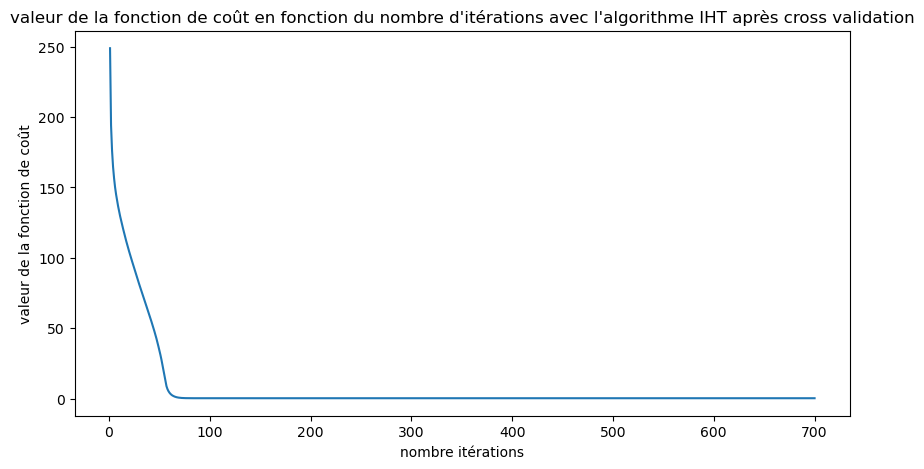

In [21]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(nbr_it_h,CV_IHT_cost)
plt.title("valeur de la fonction de coût en fonction du nombre d'itérations avec l'algorithme IHT après cross validation")  # Titre du graphique)
plt.ylabel('valeur de la fonction de coût')  # Titre de l'axe y
plt.xlabel('nombre itérations')
plt.show()

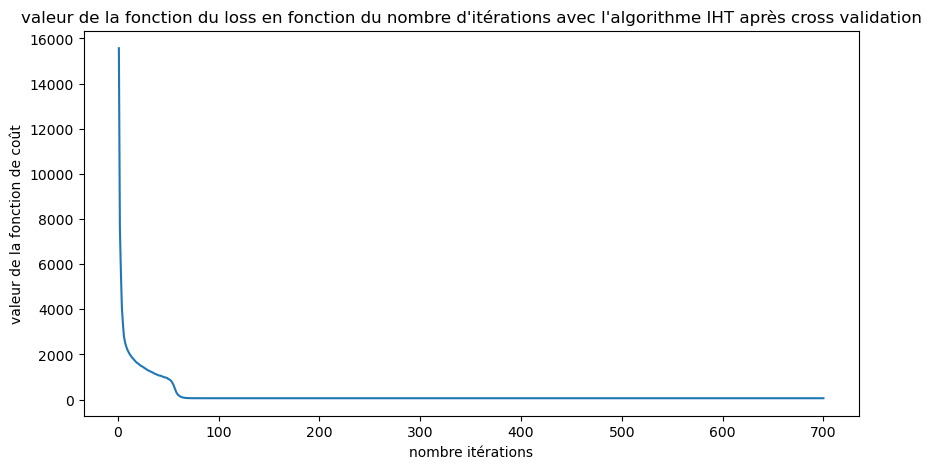

In [22]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(nbr_it_h,CV_IHT_loss)
plt.title("valeur de la fonction du loss en fonction du nombre d'itérations avec l'algorithme IHT après cross validation")  # Titre du graphique)
plt.ylabel('valeur de la fonction de coût')  # Titre de l'axe y
plt.xlabel('nombre itérations')
plt.show()

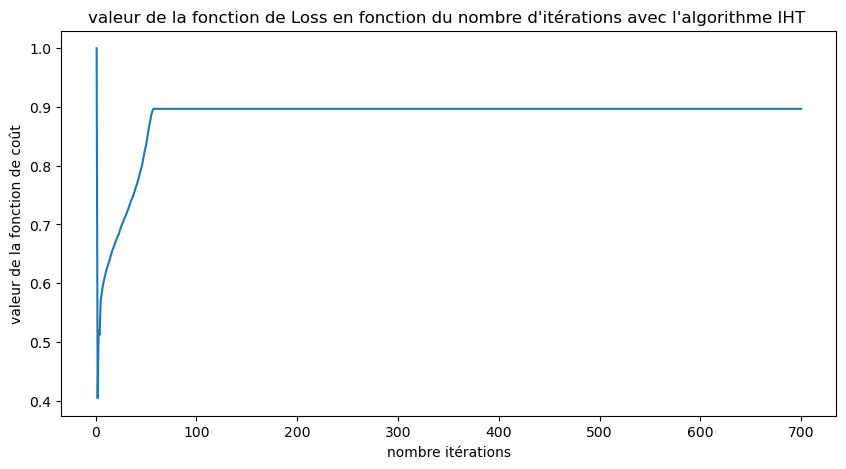

In [23]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(nbr_it,CV_IHT_sparsity)
plt.title("valeur de la fonction de Loss en fonction du nombre d'itérations avec l'algorithme IHT ")  # Titre du graphique
plt.ylabel('valeur de la fonction de coût')  # Titre de l'axe y
plt.xlabel('nombre itérations')
plt.show()

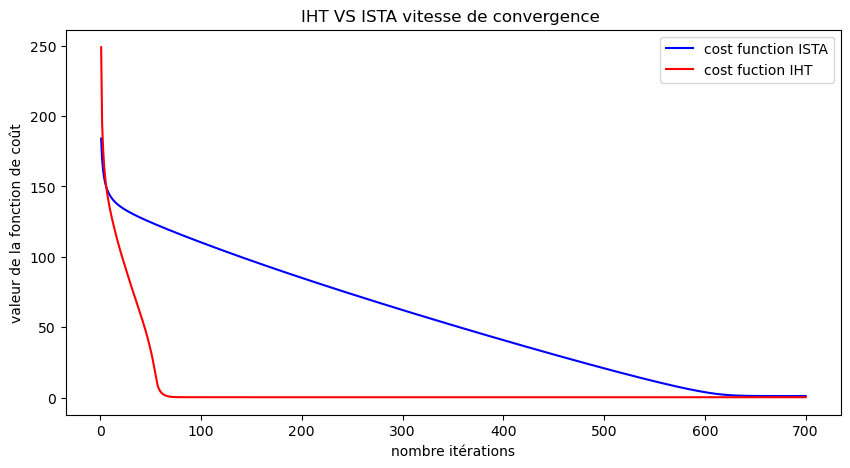

In [24]:
plt.figure(figsize=(10, 5), dpi=100)
plt.ylabel('valeur de la fonction de coût')  # Titre de l'axe y
plt.xlabel('nombre itérations')
plt.title("IHT VS ISTA vitesse de convergence ")
plt.plot(nbr_it,cost_ista, color='blue', label='cost function ISTA')
plt.plot(nbr_it_h,CV_IHT_cost, color='red',label='cost fuction IHT')
plt.legend(loc='upper right')
plt.show()

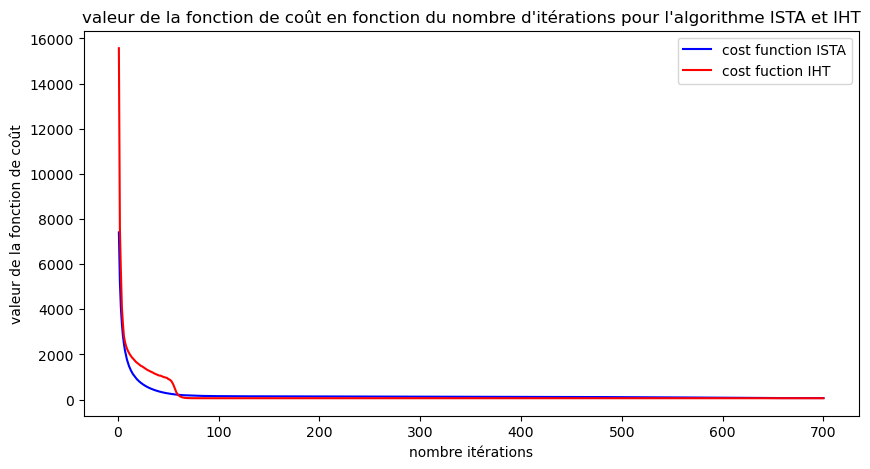

In [26]:
plt.figure(figsize=(10, 5), dpi=100)
plt.ylabel('valeur de la fonction de coût')  # Titre de l'axe y
plt.xlabel('nombre itérations')
plt.title("valeur de la fonction de coût en fonction du nombre d'itérations pour l'algorithme ISTA et IHT")
plt.plot(nbr_it,loss_ista, color='blue', label='cost function ISTA')
plt.plot(nbr_it_h,CV_IHT_loss, color='red',label='cost fuction IHT')
plt.legend(loc='upper right')
plt.show()

# Ondelettes

In [27]:
#télécharger la photo
img_path = 'random.png'
original=Image.open(img_path)

In [28]:
# application de la transofrmation en ondellettes pour rendre pouvoir rendre le vecteur representateur de l'image en noire et blanc sparse
coef_vec_BW,coeff_size_BW,coeff_shape_BW= image_processing.compress_image_BW(img_path)
# On reconstruit la photo
img_BW = image_processing.decompress_photo_BW(coef_vec_BW,coeff_size_BW,coeff_shape_BW)

Text(0.5, 1.0, 'converted photo')

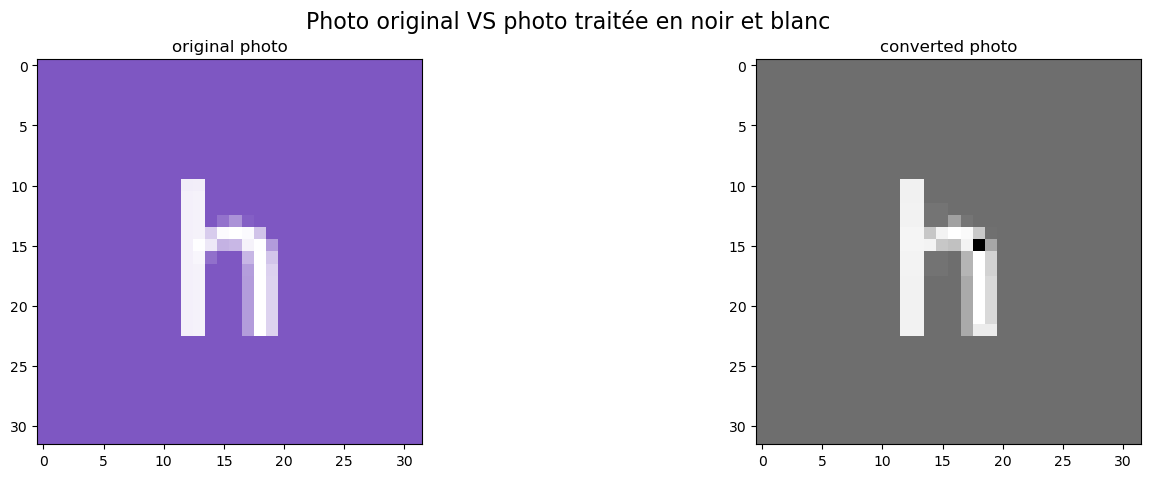

In [29]:
# On compare la photo reconstituée à la photo originale
fig, axs = plt.subplots(1,2, figsize=(17, 5))
fig.suptitle('Photo original VS photo traitée en noir et blanc', fontsize=16)
axs[0].imshow(original,cmap='gray')
axs[0].set_title('original photo')
axs[1].imshow(img_BW.astype(np.uint8),cmap='gray')
axs[1].set_title('converted photo')

In [30]:
#compute the decomposition and reconstruction of a given photo using wavelets techniques, this time we return an RGB photo
coef_vec,slices,coeff_size,coeff_shape =image_processing.compress_image_RGB(img_path,threshold=0,n_lev=1)
img,Y_im,Cb_im,Cr_im = image_processing.decompress_photo_RGB(coef_vec,slices,coeff_size,coeff_shape,wt='haar')
#save the photo
#img.save('test.jpg')

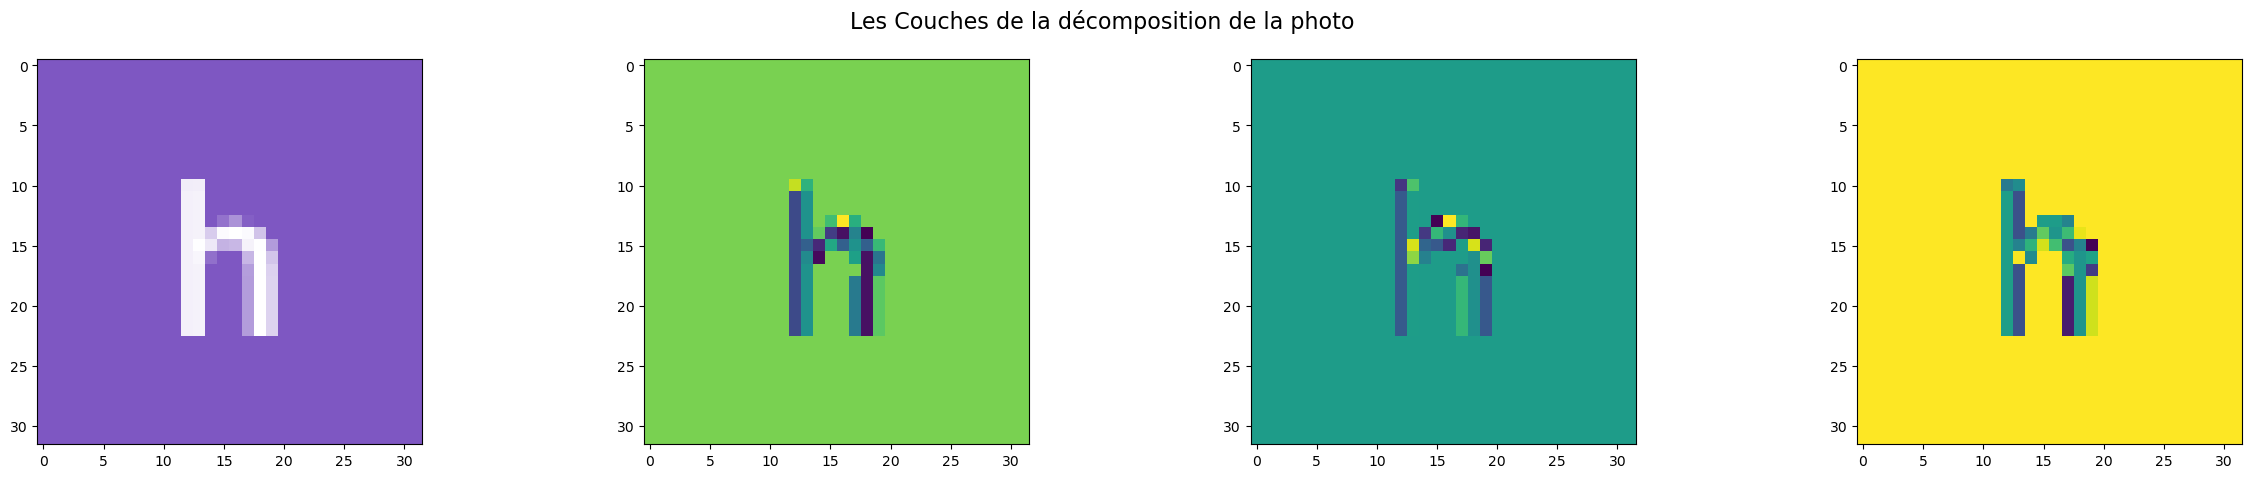

In [31]:
# visualisation des niveaux sur lesquelles on a effectué la transformation en ondelettes, puisque on n'opte pas pour la décomposition RGB de la photo mais plutôt YCbCR
fig, axs = plt.subplots(1,4, figsize=(30, 5))
axs = axs.ravel()
decomposed=[Y_im,Cb_im,Cr_im]
fig.suptitle('Les Couches de la décomposition de la photo', fontsize=16)
axs[0].imshow(original,cmap='gray')
for i in range(3):
  axs[i+1].imshow(decomposed[i])

Text(0.5, 1.0, 'converted photo')

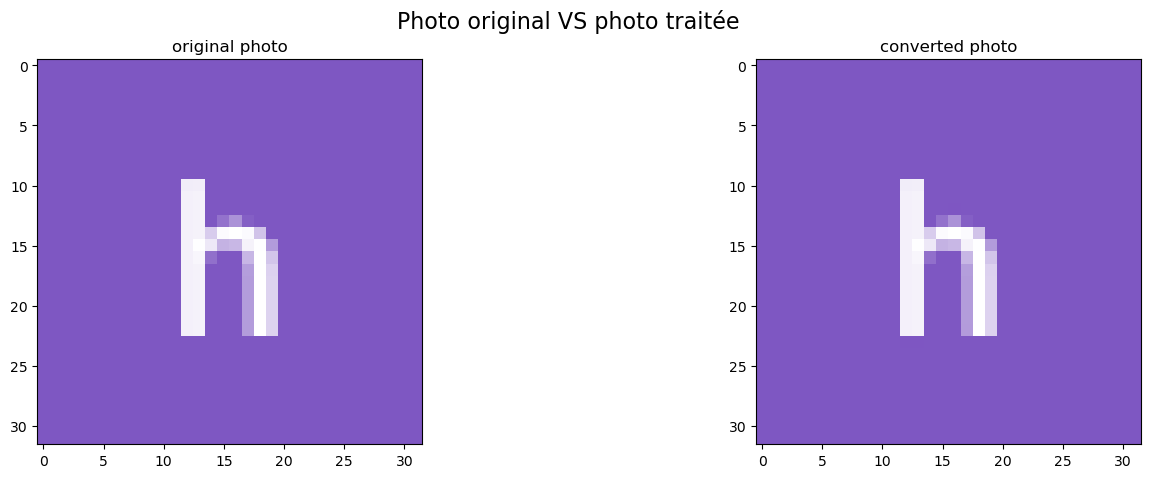

In [32]:
# On compare la photo reconstituée à la photo originale
fig, axs = plt.subplots(1,2, figsize=(17, 5))
fig.suptitle('Photo original VS photo traitée', fontsize=16)
axs[0].imshow(original)
axs[0].set_title('original photo')
axs[1].imshow(img)
axs[1].set_title('converted photo')

### On évalue la transformation en ondelettes

In [40]:
print(f"indice de sparsité du vecteur obtenu avec la transformation en ondelelettes:{round(theoretical_coeff.indice_sparsite(coef_vec)*100,2)}%")
print(f"indice de prox sparsité du vecteur obtenu avec la transformation en ondelelettes:{round(theoretical_coeff.proxy_sparsité(coef_vec),2)}")
print(f"indice de sparsité du vecteur obtenu de l'image d'origine:{round(theoretical_coeff.indice_sparsite(image_processing.read_image(img_path))*100,2)}%")
print(f"indice de prox sparsité du vecteur obtenu de l'image d'origine:{round(theoretical_coeff.proxy_sparsité(image_processing.read_image(img_path)),2)}")

indice de sparsité du vecteur obtenu avec la transformation en ondelelettes:29.79%
indice de prox sparsité du vecteur obtenu avec la transformation en ondelelettes:0.5
indice de sparsité du vecteur obtenu de l'image d'origine:100.0%
indice de prox sparsité du vecteur obtenu de l'image d'origine:19.45


# Test the IHT/ISTA algorithmes

## On commence par tester les algorithmes sur la photo en noire et blanc

### Performances des algorithmes

In [43]:
#On regarde les coefficients théorique avant et après la compression qu'on compte effectuer
p=coef_vec_BW.shape[0]
n=theoretical_coeff.compression_dimension(coef_vec_BW)
print(f"la dimension d'origine de la photo après l'analyse en ondellette est égale à: {p}")
print(f"la dimension  après compression est égale à : {n}")

la dimension d'origine de la photo après l'analyse en ondellette est égale à: 1024
la dimension  après compression est égale à : 583


In [44]:
# On définit une matrice normale qui va servir à effectuer la compression
X_test=random.matrix_normal(n,p)
Y_test=(X_test@coef_vec_BW)

In [49]:
# On performe d'abord l'algorithme ISTA 
betahat_ista_test,cost_ista_test,loss_ista_test,sparsity_ista_test=algo.ISTA(X_test,Y_test,coef_vec_BW,max_iterations=1000,lamda=1)
nbr_it = list(range(1,len(cost_ista_test)+1))

ISTA execution time : 1.6366150379180908 seconds


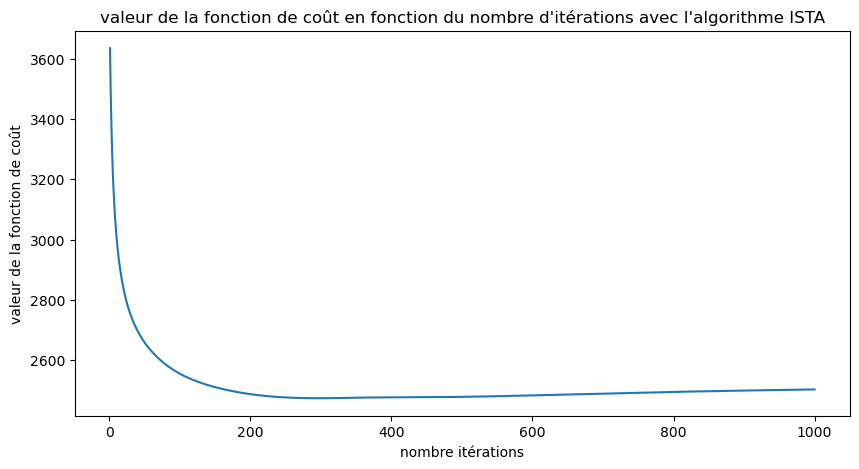

In [50]:
# On visualise les résultats 
nbr_it = list(range(1,len(cost_ista_test)+1))
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(nbr_it,cost_ista_test)
plt.title("valeur de la fonction de coût en fonction du nombre d'itérations avec l'algorithme ISTA")  # Titre du graphique)
plt.ylabel('valeur de la fonction de coût')  # Titre de l'axe y
plt.xlabel('nombre itérations')
plt.show()

In [ ]:
# On définit la liste des potentiels lamda infini possible et puis on effectue une crosse validation pour avoir le meilleur paramètre
lamda_list=np.arange(0, 1.1, 0.1)
CV_threshold=algo.IHT_CV(X=X_test, Y=Y_test, beta=coef_vec_BW, max_iterations=1000,step=(1.025e-05),lamda=100,lamda_list=lamda_list)

In [ ]:
#On performe l'algorithme IHT avec le paramètre selectionner par la cross validation
betahat_IHT_test, cost_IHT_test, loss_IHT_test1, sparsity_IHT_test1=algo.IHT(X_test, Y_test, threshold=CV_threshold, beta=coef_vec_BW, max_iterations=1000, lamda=100,step=(1.025e-05))
nbr_it_iht = list(range(1,len(cost_IHT_test)+1))

In [ ]:
# On visualise les résultats 
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(nbr_it_iht,cost_IHT_test)
plt.title("valeur de la fonction de coût en fonction du nombre d'itérations avec l'algorithme IHT ")  # Titre du graphique)
plt.ylabel('valeur de la fonction de coût')  # Titre de l'axe y
plt.xlabel('nombre itérations')
plt.show()

In [ ]:
# On compare les performences des deux algorithmes sur un cas réels
plt.figure(figsize=(10, 5), dpi=100)
plt.ylabel('valeur de la fonction de coût')  # Titre de l'axe y
plt.xlabel('nombre itérations')
plt.title("IHT VS ISTA vitesse de convergence ")
plt.plot(nbr_it,cost_ista_test, color='blue', label='cost function ISTA')
plt.plot(nbr_it_iht,cost_IHT_test, color='red',label='cost fuction IHT')
plt.legend(loc='upper right')
plt.show()

### On visualise les photos après décompression

In [51]:
decomp_img_BW_ista = image_processing.decompress_photo_BW(betahat_ista_test,coeff_size_BW,coeff_shape_BW)

Text(0.5, 1.0, 'photo décompressée')

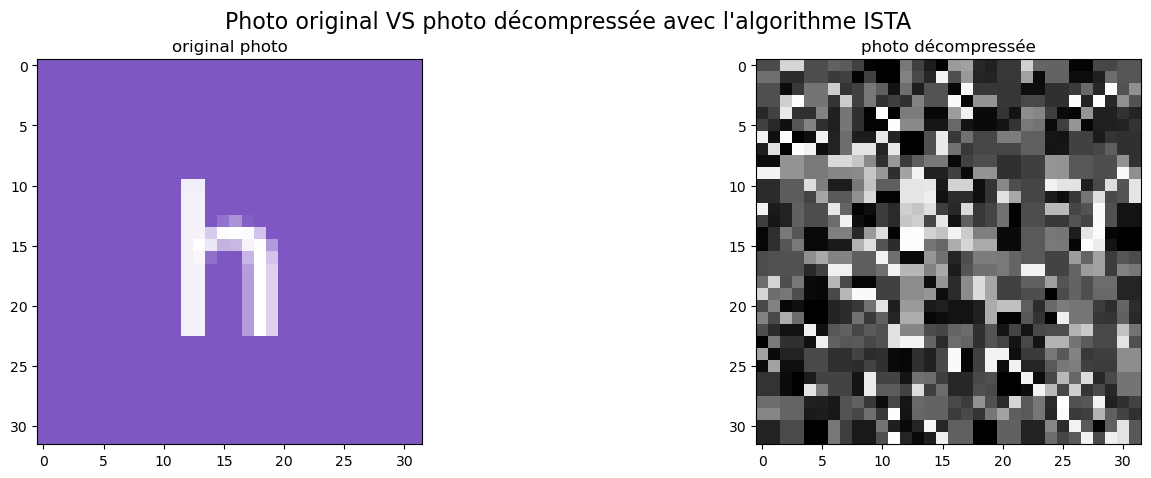

In [52]:
fig, axs = plt.subplots(1,2, figsize=(17, 5))
fig.suptitle("Photo original VS photo décompressée avec l'algorithme ISTA", fontsize=16)
axs[0].imshow(original,cmap='gray')
axs[0].set_title('original photo')
axs[1].imshow(decomp_img_BW_ista.astype(np.uint8),cmap='gray')
axs[1].set_title('photo décompressée')

In [ ]:
decomp_img_BW_IHT = image_processing.decompress_photo_BW(betahat_IHT_test,coeff_size_BW,coeff_shape_BW)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(17, 5))
fig.suptitle("Photo original VS photo décompressée avec l'algorithme IHT", fontsize=16)
axs[0].imshow(original,cmap='gray')
axs[0].set_title('original photo')
axs[1].imshow(decomp_img_BW_IHT.astype(np.uint8),cmap='gray')
axs[1].set_title('photo décompressée')

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(17, 5))
fig.suptitle("comparaison des résulats des deux algorithmes par rapport à l'image initiale", fontsize=16)
axs[0].imshow(original,cmap='gray')
axs[0].set_title('original photo')
axs[1].imshow(decomp_img_BW_IHT.astype(np.uint8),cmap='gray')
axs[1].set_title('photo décompressée avec IHT')
axs[2].imshow(decomp_img_BW_ista.astype(np.uint8),cmap='gray')
axs[2].set_title('photo décompressée avec ISTA')